In [1]:
from sklearn import svm, metrics, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,Activation,Dropout, MaxPooling1D, Conv1D, Flatten, BatchNormalization
# from tensorflow.keras.layers.normalization import BatchNormalization 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snappy
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
mask_file = r'\water_veg_mask'
mask_path = r'D:\workspace\jupyterNotebooks\Remote Sensing\Water Segmentation\data'

In [4]:
water_veg_mask = np.load(r'.\data\water_veg_mask.npy')

In [5]:
unique, counts = np.unique(water_veg_mask, return_counts=True)
print(unique, counts)
water_veg_mask = water_veg_mask.flatten()

[0 1 2] [503834  14724 135923]


In [6]:
# flag_0s = water_veg_mask == 0
# flag_1s = water_veg_mask == 1
# flag_2s = water_veg_mask == 2
# mask_0 = water_veg_mask[flag_0s]
# mask_1 = water_veg_mask[flag_1s]
# mask_2 = water_veg_mask[flag_2s]


In [7]:
# non_vegetated_data = np.random.choice(mask_0, size = len(mask_1), replace = False)
# vegetated_data = np.random.choice(mask_2, size = len(mask_1), replace =False)
# print(non_vegetated_data)
# print(vegetated_data)
# print(mask_1)

In [8]:
product_path = r'D:\Engi_Books\CDSAML\reflectance\data\subset_0_of_S1S2_collocated.dim'

In [9]:
product = snappy.ProductIO.readProduct(product_path)
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()

In [10]:
# B2 = product.getBand('B2_S')
# B3 = product.getBand('B3_S')
# B4 = product.getBand('B4_S')
# B5 = product.getBand('B5_S')
# B6 = product.getBand('B6_S')
# B7 = product.getBand('B7_S')
# B8 = product.getBand('B8_S')
# B8A = product.getBand('B8A_S')
# B11 = product.getBand('B11_S')
# B12 = product.getBand('B12_S')
VV = product.getBand('Sigma0_VV_db_M')
VH = product.getBand('Sigma0_VH_db_M')

In [11]:
# B2_pixels = np.zeros(width * height, np.float32)
# B2.readPixels(0,0,width,height,B2_pixels)
# B2_pixels.flatten()

# B3_pixels = np.zeros(width * height, np.float32)
# B3.readPixels(0,0,width,height,B3_pixels)
# # B3_pixels.flatten()

# B4_pixels = np.zeros(width * height, np.float32)
# B4.readPixels(0,0,width,height,B4_pixels)
# # B4_pixels.flatten()

# B5_pixels = np.zeros(width * height, np.float32)
# B5.readPixels(0,0,width,height,B5_pixels)

# B6_pixels = np.zeros(width * height, np.float32)
# B6.readPixels(0,0,width,height,B6_pixels)

# B7_pixels = np.zeros(width * height, np.float32)
# B7.readPixels(0,0,width,height,B7_pixels)

# B8_pixels = np.zeros(width * height, np.float32)
# B8.readPixels(0,0,width,height,B8_pixels)
# # B8_pixels.flatten()

# B8A_pixels = np.zeros(width * height, np.float32)
# B8A.readPixels(0,0,width,height,B8A_pixels)

# B11_pixels = np.zeros(width * height, np.float32)
# B11.readPixels(0,0,width,height,B11_pixels)

# B12_pixels = np.zeros(width * height, np.float32)
# B12.readPixels(0,0,width,height,B12_pixels)

VV_pixels = np.zeros(width*height, np.float32)
VV.readPixels(0,0,width,height,VV_pixels)

VH_pixels = np.zeros(width*height, np.float32)
VH.readPixels(0,0,width,height,VH_pixels)

array([-11.6677265, -12.797009 , -14.170678 , ..., -20.18223  ,
       -19.282478 , -18.462933 ], dtype=float32)

In [12]:
# print(water_veg_mask.shape)
# print(B2_pixels.shape)
# print(B3_pixels.shape)
# print(B8_pixels.shape)
# print(B8_pixels.shape)

In [13]:
df = pd.DataFrame({
#                    'B2':B2_pixels, 
#                    'B3': B3_pixels,
#                    'B4': B4_pixels,
#                    'B5': B5_pixels,
#                    'B6': B6_pixels,
#                    'B7': B7_pixels,
#                    'B8': B8_pixels,
#                    'B8A': B8A_pixels,
#                    'B11': B11_pixels,
#                    'B12': B12_pixels,
                    'VV': VV_pixels,
                    'VH': VH_pixels,
                    'Y':water_veg_mask})
#df.drop(df[df.X == 0].index,inplace=True)

In [14]:
df.head()

,VV,VH,Y
0,-8.640436,-11.667727,2
1,-9.827668,-12.797009,2
2,-10.791497,-14.170678,2
3,-11.327498,-14.757204,0
4,-11.777595,-15.981637,0


In [15]:
x_cols = ['VV', 'VH']


In [16]:
# plt.subplots(figsize=(10,10))
# sns.heatmap(df.corr(method='spearman'), annot=True, cmap='coolwarm')

In [17]:
sample_0 = df.query('Y == 0').sample(counts[1])
sample_1 = df.query('Y == 1').sample(counts[1])
sample_2 = df.query('Y == 2').sample(counts[1])


In [18]:
sampled_df = pd.concat([sample_0, sample_1, sample_2],keys=['VV', 'VH','Y'])
sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)
sampled_df.describe()

,VV,VH,Y
count,44172.000000,44172.000000,44172.000000
mean,-11.533970,-17.308809,1.000000
std,6.309126,4.513200,0.816506
min,-24.973480,-27.950575,0.000000
25%,-18.125326,-22.085068,0.000000
50%,-10.045039,-16.035169,1.000000
75%,-7.429053,-13.910251,2.000000
max,30.754570,14.855267,2.000000


In [19]:
# sns.heatmap(sampled_df.corr(method='spearman'), annot=True, cmap='coolwarm')

In [20]:
X_train,X_test_val,y_train,y_test_val = train_test_split(sampled_df[x_cols],sampled_df['Y'],test_size=0.4,random_state=1234, stratify = sampled_df['Y'])

In [21]:
X_test,X_val, y_test, y_val = train_test_split(X_test_val,y_test_val,test_size=0.5,random_state=4321, stratify = y_test_val)

In [22]:
def show_confusion_matrix(y_test, y_pred, score):    
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    return cm


In [23]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
lr_pred1 = logisticRegr.predict(X_test)
lr_score = logisticRegr.score(X_test, y_test)
print(f"Testing accuracy of Logistic Regression = {lr_score}")
lr_pred2 = logisticRegr.predict(X_val)
lr_val_score = logisticRegr.score(X_val, y_val)
print(f"Validation accuracy of Logistic Regression = {lr_val_score}")

Testing accuracy of Logistic Regression = 0.7285487887706589
Validation accuracy of Logistic Regression = 0.7283531409168081


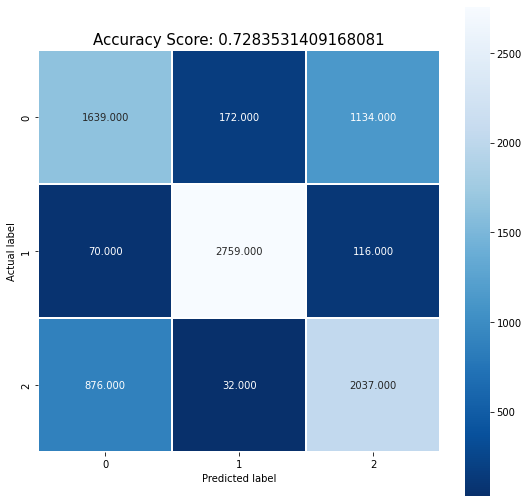

In [24]:
cm = show_confusion_matrix(y_test = y_val, y_pred = lr_pred2, score = lr_val_score)

Kernel: rbf
Testing Accuracy SVM: 0.7570749377405479
validation Accuracy SVM: 0.7581211092246746


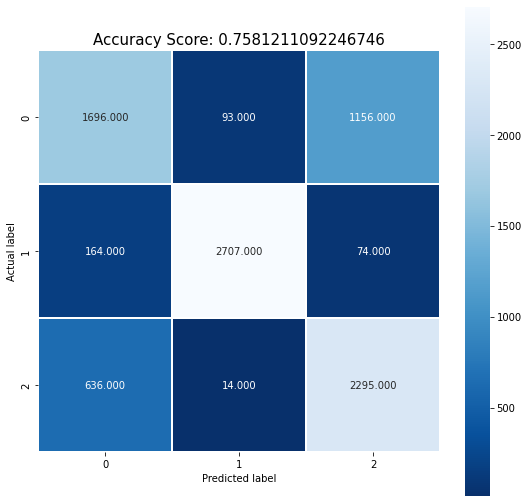

In [25]:
kernels = ['rbf']
for kernel in kernels:
    clf = svm.SVC(kernel = kernel, C = 100000 )
    clf.fit(X_train, y_train)
    svm_y_pred1 = clf.predict(X_test)
    print("Kernel:",kernel)
    svm_y_test_acc = metrics.accuracy_score(y_test, svm_y_pred1)
    print("Testing Accuracy SVM:",svm_y_test_acc)
    svm_y_pred_val = clf.predict(X_val)
    svm_y_val_acc = metrics.accuracy_score(y_val, svm_y_pred_val)
    print("validation Accuracy SVM:",svm_y_val_acc)
    cm = show_confusion_matrix(y_test = y_val, y_pred = svm_y_pred_val, score = svm_y_val_acc)

Testing Gaussian Naive Bayes Accuracy: 0.7457550373556713
Validation Accuracy GNB: 0.7426146010186757


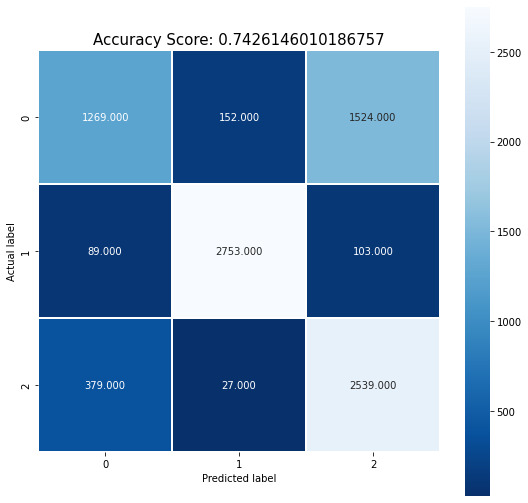

In [26]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_y_pred = gnb.predict(X_test)
gnb_y_val = gnb.predict(X_val)
gnb_y_test_acc = metrics.accuracy_score(y_test, gnb_y_pred)
gnb_y_val_acc = metrics.accuracy_score(y_val, gnb_y_val)
print("Testing Gaussian Naive Bayes Accuracy:",gnb_y_test_acc)
print(f"Validation Accuracy GNB: {gnb_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = gnb_y_val, score = gnb_y_val_acc)

Testing Accuracy of Random Forest classifier for 100 estimators = 0.7280959927552637
Validation Accuracy of Random Forest classifier for 100 estimators = 0.7247311827956989


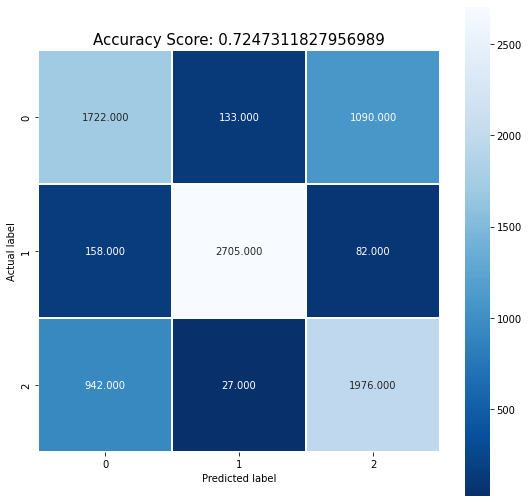

In [27]:
est = 100
rfc = RandomForestClassifier(n_estimators = est)
rfc.fit(X_train, y_train) 
rfc_y_pred = rfc.predict(X_test) 
rfc_y_val = rfc.predict(X_val)
rfc_y_test_acc = metrics.accuracy_score(y_test, rfc_y_pred)
rfc_y_val_acc = metrics.accuracy_score(y_val, rfc_y_val)
print(f"Testing Accuracy of Random Forest classifier for {est} estimators = {rfc_y_test_acc}")
print(f"Validation Accuracy of Random Forest classifier for {est} estimators = {rfc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = rfc_y_val, score = rfc_y_val_acc)

Testing Accuracy of 7 Nearest Neighbour classifier = 0.7287751867783564
Validation Accuracy of 7 Nearest Neighbour classifier = 0.7329937747594794


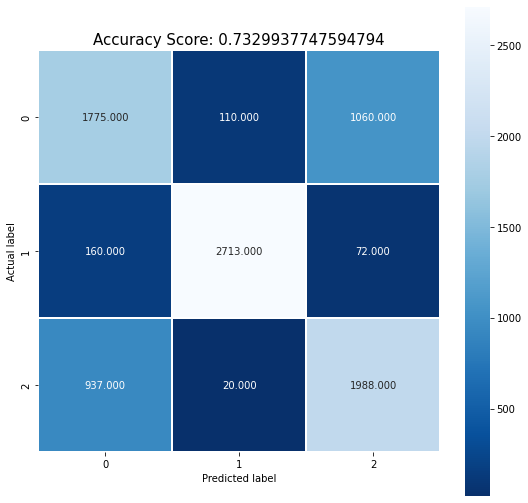

In [28]:
k = 7
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_y_val = knn.predict(X_val)
knn_y_test_acc = metrics.accuracy_score(y_test, knn_y_pred)
knn_y_val_acc = metrics.accuracy_score(y_val, knn_y_val)
print(f"Testing Accuracy of {k} Nearest Neighbour classifier = {knn_y_test_acc}")
print(f"Validation Accuracy of {k} Nearest Neighbour classifier = {knn_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = knn_y_val, score = knn_y_val_acc)

Testing Accuracy of Decision Tree classifier = 0.681005207154177
Validation Accuracy of Decision Tree classifier = 0.6896434634974533


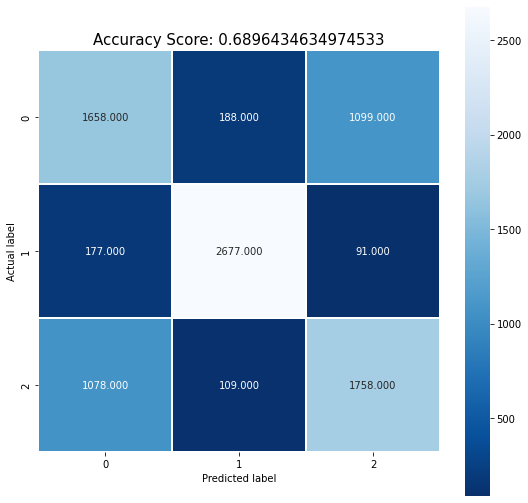

In [29]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)
dtc_y_val = dtc.predict(X_val)
dtc_y_test_acc = metrics.accuracy_score(y_test, dtc_y_pred)
dtc_y_val_acc = metrics.accuracy_score(y_val, dtc_y_val)
print(f"Testing Accuracy of Decision Tree classifier = {dtc_y_test_acc}")
print(f"Validation Accuracy of Decision Tree classifier = {dtc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = dtc_y_val, score = dtc_y_val_acc)

Testing Accuracy of Stochastic Gradient Descent classifier| loss = modified_huber | penalty = l1| max iterations = 25|= 0.7174552863934798
Validation Accuracy of Stochastic Gradient Descent classifier| loss = modified_huber | penalty = l1| max iterations = 25|= 0.7190718732314657


d:\users\shubh\anaconda3\envs\snap1\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


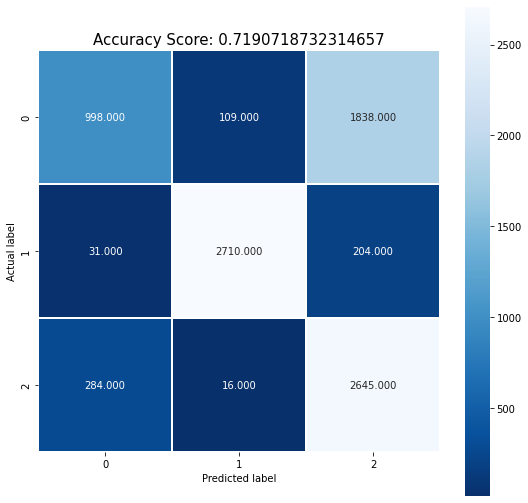

In [30]:
loss = "modified_huber"
penalty = "l1"
max_iterations = 25
sgdc = SGDClassifier(loss=loss, penalty=penalty, max_iter=max_iterations)
sgdc.fit(X_train, y_train)
sgdc_y_pred = sgdc.predict(X_test)
sgdc_y_val = sgdc.predict(X_val)
sgdc_y_test_acc = metrics.accuracy_score(y_test, sgdc_y_pred)
sgdc_y_val_acc = metrics.accuracy_score(y_val, sgdc_y_val)
print(f"Testing Accuracy of Stochastic Gradient Descent classifier| loss = {loss} | penalty = {penalty}| max iterations = {max_iterations}|= {sgdc_y_test_acc}")
print(f"Validation Accuracy of Stochastic Gradient Descent classifier| loss = {loss} | penalty = {penalty}| max iterations = {max_iterations}|= {sgdc_y_val_acc}")
cm = show_confusion_matrix(y_test = y_val, y_pred = sgdc_y_val, score = sgdc_y_val_acc)

d:\users\shubh\anaconda3\envs\snap1\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Testing Accuracy of XGBoost classifier = 75.18677835635046
Validation Accuracy of XGBoost classifier = 75.50650820599887


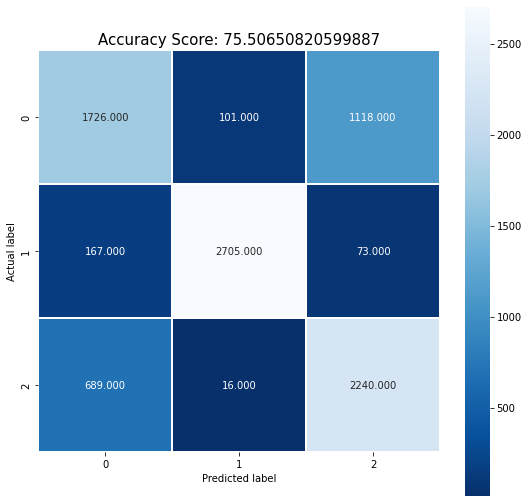

In [31]:
xgbc = XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_y_pred = xgbc.predict(X_test) 
xgbc_y_val = xgbc.predict(X_val) 
xgbc_predictions = [round(value) for value in xgbc_y_pred]
xgbc_validations = [round(value) for value in xgbc_y_val]
xgbc_accuracy_test = accuracy_score(y_test, xgbc_predictions) * 100.0
xgbc_accuracy_val = accuracy_score(y_val, xgbc_validations) * 100.0
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Testing Accuracy of XGBoost classifier = {xgbc_accuracy_test}")
print(f"Validation Accuracy of XGBoost classifier = {xgbc_accuracy_val}")
cm = show_confusion_matrix(y_test = y_val, y_pred = xgbc_validations, score = xgbc_accuracy_val)

In [32]:
y_train= to_categorical(y_train,num_classes=3)
y_test= to_categorical(y_test,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)
print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)
print("Shape of y_val",y_val.shape)

Shape of y_train (26503, 3)
Shape of y_test (8834, 3)
Shape of y_val (8835, 3)


In [33]:
# # Multi layer perceptron
# optimizer = Adam(lr=0.001)
# model_mlp= keras.Sequential()
# model_mlp.add(layers.Dense(4,input_dim=4))
# model_mlp.add(layers.Dense(64))
# model_mlp.add(layers.Dense(32))
# model_mlp.add(layers.Dropout(0.4))
# model_mlp.add(layers.Dense(3))
# model_mlp.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])

In [34]:
# simple early stopping
es = EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    min_delta=0.001, 
    restore_best_weights=True
)
# mc = ModelCheckpoint(filepath = r'.\data\best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [35]:
# model_mlp.summary()

In [36]:
# history_mlp = model_mlp.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=200,verbose=1, callbacks = [es])

In [37]:
# saved_model = load_model(r'.\data\best_model.h5')

In [38]:
# prediction_mlp=model_mlp.predict(X_val)
# length=len(prediction_mlp)
# y_label=np.argmax(y_val,axis=1)
# predict_label_mlp=np.argmax(prediction_mlp,axis=1)

# accuracy_mlp=np.sum(y_label==predict_label_mlp)/length * 100 
# print("Validation Accuracy of the multi layer perceptron",accuracy_mlp )
# cm = show_confusion_matrix(y_test = y_label, y_pred = predict_label_mlp, score = accuracy_mlp)

In [39]:
# with tf.device('/gpu:0'):
#     inputs = keras.Input(shape=(10,))
#     dense_1 = layers.Dense(32, activation="elu")
#     dense_2 = layers.Dense(32, activation="selu")
#     dense_3 = layers.Dense(32, activation="relu")
#     # dropout = layers.Dropout(0.4)
#     x = dense_1(inputs)
#     y = dense_2(inputs)
#     z = dense_3(inputs)
#     # x = layers.Dropout(0.4)(x)
#     x_skip = x
#     x = layers.Dropout(0.25)(x)
#     x = layers.Dense(32, activation="elu")(x)
#     x = keras.layers.add([x,x_skip])

#     y_skip = y
#     y = layers.Dropout(0.25)(y)
#     y = layers.Dense(32, activation="selu")(y)
#     y = keras.layers.add([y,y_skip])

#     z_skip = z
#     z = layers.Dropout(0.25)(z)
#     z = layers.Dense(32, activation="relu")(z)
#     z = keras.layers.add([z, z_skip])

#     # x = layers.Dropout(0.4)(x)

#     x_skip = x
#     x = layers.Dropout(0.25)(x)
#     x = layers.Dense(32, activation="elu")(x)
#     x = keras.layers.add([x,x_skip])

#     y_skip = y
#     y = layers.Dropout(0.25)(y)
#     y = layers.Dense(32, activation="selu")(y)
#     y = keras.layers.add([y,y_skip])

#     z_skip = z
#     z = layers.Dropout(0.25)(z)
#     z = layers.Dense(32, activation="relu")(z)
#     z = keras.layers.add([z, z_skip])


#     # x_skip = x
#     # x = layers.Dense(32, activation="elu")(x)
#     # x = keras.layers.add([x,x_skip])
#     # y_skip = y
#     # y = layers.Dense(32, activation="selu")(y)
#     # y = keras.layers.add([y,y_skip])
#     # x = layers.Dropout(0.4)(x)
#     # x_skip = x
#     # x = layers.Dense(128, activation="elu")(x)
#     # x = keras.layers.add([x,x_skip])
#     # # x = layers.Dropout(0.4)(x)
#     # x_skip = x
#     # x = layers.Dense(128, activation="elu")(x)
#     # x = keras.layers.add([x,x_skip])
#     # x = layers.Dropout(0.4)(x)
#     # x_skip = x
#     # x = layers.Dense(128, activation="elu")(x)
#     # x = keras.layers.add([x,x_skip])
#     merge_1 = keras.layers.add([x,y])
#     merge_2 = keras.layers.add([y,z])
#     # x = layers.Dropout(0.4)(x)
#     outputs = layers.Dense(3, activation="softmax")(keras.layers.add([merge_1,merge_2]))
#     model_keras = keras.Model(inputs=inputs, outputs=outputs, name="keras_v2_4band")
    
#     print(model_keras.summary())
    
#     model_png = keras.utils.plot_model(
#         model_keras,
#         to_file=r'.\data\model_residual.png',
#         show_shapes=False,
#         show_layer_names=True,
#         rankdir="TB",
#         expand_nested=False,
#         dpi=96,
#     )
    
#     model_keras.compile(
#         loss=keras.losses.CategoricalCrossentropy(),
#         optimizer=keras.optimizers.Adam(),
#         metrics=["accuracy"],
#     )


In [40]:
# with tf.device('/gpu:0'):
#     history_keras = model_keras.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=64,epochs=200,verbose=1, callbacks = [es])

In [41]:
# with tf.device('/gpu:0'):
#     prediction_keras=model_keras.predict(X_val)
#     length=len(prediction_keras)
#     y_label=np.argmax(y_val,axis=1)
#     predict_label_keras=np.argmax(prediction_keras,axis=1)

#     accuracy_keras=np.sum(y_label==predict_label_keras)/length * 100 
#     print("Validation Accuracy of Neural Network",accuracy_keras )
#     cm = show_confusion_matrix(y_test = y_label, y_pred = predict_label_keras, score = accuracy_keras)